In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)

import math
import glob
import io
import base64
from IPython.display import HTML

from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400,900),)
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1055'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1055'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
# if is_ipython:
#     from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [0]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs, hidden_size = 256):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding =1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding =1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        def conv2d_size_out(size, kernel_size = 5, stride = 2, padding = 0):
            return (size + padding*2 - kernel_size) // stride  + 1
            
        convw = conv2d_size_out(conv2d_size_out(w, 4,2,1),4,2,1)
        convh = conv2d_size_out(conv2d_size_out(h, 4,2,1),4,2,1)

        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        )

        convw = int(w/4)
        convh = int(h/4)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        linear_input_size = convw * convh * 32 * 2
        self.linear = nn.Sequential(
            nn.Linear(linear_input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size ,outputs)
        )

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x1 = self.conv_3x3(x)
        x2 = self.conv(x)
        x = torch.cat((x1,x2), 1)
        x = x.view(x.size(0), -1)
        return self.linear(x) 

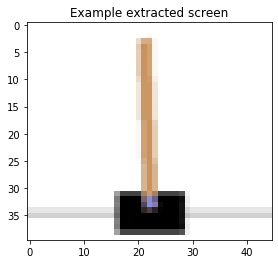

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.3)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [0]:
BATCH_SIZE = 128
GAMMA = 0.95
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2000
TARGET_UPDATE = 10
LR = 0.0004
HIDDEN = 64

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions, HIDDEN).to(device)
target_net = DQN(screen_height, screen_width, n_actions, HIDDEN).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

#optimizer = optim.RMSprop(policy_net.parameters(), lr=LR)
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())


In [0]:
criterion = nn.MSELoss()

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.ones(BATCH_SIZE, device=device)*-10000
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    #loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # for param in policy_net.parameters():
    #     param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [0]:
num_episodes = 2000
frame_saved = []
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()

    if i_episode%TARGET_UPDATE == TARGET_UPDATE-1:
      frames= []
      frames.append(env.render(mode="rgb_array"))

    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        if i_episode%TARGET_UPDATE == TARGET_UPDATE-1:
          frames.append(env.render(mode="rgb_array"))
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            if i_episode%20 == 0:
                print("[%3d]"% i_episode, end="")
            #plot_durations()
            print("%3d"%t, end=" ")
            if i_episode%20 == 19:
                print()
            if i_episode%TARGET_UPDATE == TARGET_UPDATE-1:
              frame_saved.append((i_episode, t, frames))
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

[  0] 18  32  14  19  20  47  19  13  24  22  15   8  19  12  14  23  11   9  21  14 
[ 20] 21  15  17   8  43  22  15  29  12  26  15  10  15  11  21  13  23  15  10  28 
[ 40] 11  16  19  19  12  11  13  26  48  14   8  22   9   8   9  16  12  17   8  11 
[ 60] 11  11  11   8  10  44  30  18  13  14  25  12  25  12  10  12  11  10  24  10 
[ 80]  9  11  23  10  12  10   8  14   9  10   8  11  12  21   9  10  13  13  11  12 
[100] 15  14  20  10  10  10   9  13   8  13   9  18   9  17  12  13  12  10   9  25 
[120] 21  12  27  25  19  25  14   9  12  28  17  20   8  32  15  11  11   9  10  12 
[140]  9  15  13  11  11   8  10  10  14  25  23   9  17  17  11  12   9  11  10  12 
[160] 21  11   9   8  14   8  11   8  11   8   9   8  16  29  56   7  31  17  13  45 
[180] 15  19  11   9  11 144  18  13  12  17  22  48   8  12  16 143  13  12  14  11 
[200] 28  14  35  14  12  94  66  11  12  15  12  47 160  11  22 118  15  26 341 352 
[220]540 181 275 194 167 424 163 213 425 237 356 617 2

In [0]:
!pip install JSAnimation
from matplotlib import animation, rc
from JSAnimation.IPython_display import display_animation
from IPython.display import display
import os
import glob
import io
# Imports specifically so we can render outputs in Colab.
fig = plt.figure()
def display_frames_as_gif(frame):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frame[0].astype(int))
    def animate(i):
        patch.set_data(frame[i].astype(int))
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frame), interval=30, blit=False
    )
    #display(display_animation(anim, default_mode='loop'))
    # Set up formatting for the movie files
    display(HTML(data=anim.to_html5_video()))
    #FFwriter = animation.FFMpegWriter()
    #anim.save('basic_animation.mp4', writer = FFwriter)
    #show_video()
# display 

In [0]:
fig = plt.figure()
print(frame_saved[-1][0], frame_saved[-1][1])
display_frames_as_gif(frame_saved[-1][2])